In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [10]:
data = pd.read_csv("Medicalpremium.csv")

In [210]:
df = data.copy()

In [212]:
X = df.drop("PremiumPrice", axis=1)
y = df.PremiumPrice.copy()

In [221]:
num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
num_cols

['Age', 'Height', 'Weight']

In [222]:
num_cols + ["BMI"]

['Age', 'Height', 'Weight', 'BMI']

In [214]:
from sklearn.base import BaseEstimator, TransformerMixin

In [352]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    return X
            else:
                return X
        else:
            return X

In [353]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [354]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
        self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [355]:
pipe = Pipeline([
    ('bmi', BMI(bmi=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler())
])

In [361]:
X_scaled = pd.DataFrame(pipe.fit_transform(X.copy()))

In [362]:
X_scaled

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,Height,Weight
0,0,0,0,0,0,0,0,0.233197,-1.306105,-1.399250
1,1,0,0,0,0,0,0,1.307981,1.170852,-0.277062
2,1,1,0,0,0,0,1,-0.411674,-1.008870,-1.258976
3,1,1,0,1,0,0,2,0.734763,1.468086,1.125674
4,0,0,0,1,0,0,1,-0.268369,-0.216244,0.774990
...,...,...,...,...,...,...,...,...,...,...
981,0,0,0,0,0,0,0,-1.701415,0.080991,-0.697882
982,1,1,0,0,0,0,3,1.594590,-1.504261,-0.487472
983,0,1,0,0,0,0,1,1.021372,-1.306105,-0.417335
984,1,1,0,0,1,0,1,0.376502,-1.008870,-0.277062


In [364]:
from sklearn.model_selection import train_test_split

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest

In [377]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [368]:
forest_reg = RandomForestRegressor()

In [369]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [374]:
pred = forest_reg.predict(X_test)

In [379]:
np.sqrt(mean_squared_error(y_test, pred))

2247.6032127624753

In [378]:
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=5)

In [380]:
forest_rmse_scores = np.sqrt(-scores)

In [381]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [382]:
display_scores(forest_rmse_scores)

Scores: [3421.55980789 3217.43234367 3484.12284877 2627.81726284 2537.00372449]
Mean: 3057.5871975323453
Standard deviation: 398.91566596948684


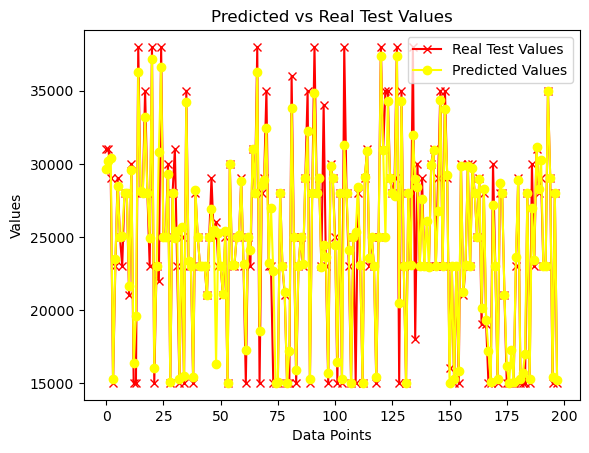

In [397]:
# Plotting
x = np.arange(0, len(pred), 1)
plt.plot(x, y_test, label='Real Test Values', marker='x', c="red")
plt.plot(x, pred, label='Predicted Values', marker='o', c="yellow")


# Adding labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.legend()

# Show the plot
plt.show()